# Upwelling analysis

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import yaml
import os
import gsw
from cmocean import cm
from scipy import signal
from tqdm.notebook import tqdm
from salishsea_tools import geo_tools, viz_tools

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

***

### Define variables and load reference datasets

In [3]:
# Load mask and bathymetry
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')

with open('parameters.yaml') as f: grids, _, _ = yaml.safe_load_all(f)
    
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'h_s': [10, 15, 20],
    'rho_s': [1016, 1018, 1020],
}

const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024}

***

### Calculate coastline indices

In [4]:
def calc_coastline_indices(tmask, bathy, L=1e4, H=100, e1t=440):
    """Find the NEMO-SalishSeaCast j, i pairs along the western coastline.                                      
    Also finds the coastline angle CW from north-south, and the average cross-                                  
    shore bottom slope between zero and 200 m depth. I would prefer this                                        
    routine to be flexible to various choices of jmin, jmax and jsub but in                                     
    reality it takes a bit of tuning to avoid errors.                                                           
    """

    # Mask out Gulf Islands
    tmask[:, :450, :230] = 0
    
    # Indexing parameters                                                                                       
    imin, jmin, jmax, jsub = 115, 355, 730, 5
    jignore = [365, 370, 430, 460, 485, 490, 515, 595, 600, 615, 635, 640, 645, 650]
    
    # Create jindex
    jcoast = np.arange(jmin, jmax, jsub)
    jignore = np.array([j in jignore for j in jcoast])
    jcoast = jcoast[~jignore]
    
    # Build angle array (angles and ranges were chosen manually)
    jcut = [0, 360, 405, 425, 460, 555, 570, 600, 650, 695, 897]
    angles = [-0.55, -0.35, -0.2, -0.1, -0.6, -0.45, -0.25, -0.3, -0.25, -0.1]
    angle = np.zeros(len(jcoast))
    for j0, j1, a in zip(jcut[:-1], jcut[1:], angles):
        angle[(jcoast > j0) & (jcoast <= j1)] = a

    # Initialize index array                                                   
    icoast, isect, jsect, slope = [], [], [], []

    # Iterate through jindex                                                                                    
    for j, a in zip(jcoast, angle):

        # Find i at coast                                                                    
        i, i_d = [np.where(abs(np.diff(tmask[k, j, imin:])) > 0)[0] for k in [0, 29]]                                                                  
        i = i[i < i_d[0]][-1] + imin
        
        # Define offshore sections
        d = L / e1t
        i_s = np.linspace(i, i + np.cos(a) * d, int(d)).astype(int)
        j_s = np.linspace(j, j - np.sin(a) * d, int(d)).astype(int)
        
        # Find j, i of deep isobath (or slightly shallower if necessary) and slope
        index, h = [0], H + 1
        while sum(index) == 0:
            h += -1
            index = np.array([float(bathy[y, x]) for y, x in zip(j_s, i_s)]) > h
        index = index.nonzero()[0][0]
        j_d, i_d = j_s[index], i_s[index]
        s = h / (np.sqrt((i_d - i)**2 + (j_d - j)**2) * e1t)
        
        # Append new values
        icoast.append(i)
        isect.append(i_s)
        jsect.append(j_s)
        slope.append(s)

    # Populate sections dict
    sections = {
        'ji': [jcoast, np.array(icoast)],
        'ji_sect': [np.array(jsect), np.array(isect)],
        'angle': np.array(angle), 'slope': np.array(slope), 'n': len(jcoast),
    }

    return sections

***

### Process idealized results

In [5]:
def calc_rho(data, depth, tmask):
    """                                                                        
    """

    # Calculate density
    tracers = ['vosaline', 'votemper']
    rho = gsw.rho(*[np.ma.masked_where(tmask == 0, data[k]) for k in tracers], depth)

    return rho


def calc_upwelling_parameters(rho_t1, rho_t0, rho_pyc, deptht, e1t=440, angle=0, L=50):
    """                                                                                                     
    """

    # Calculate upwelling parameters                                                                        
    rho_max = rho_t1[:L].max()
    h_u = deptht[int(np.median(abs(rho_t0[:, :L] - rho_max).argmin(axis=0)))]

    return h_u


def process_idealized_results(
    param, sections, mask, subgrid, hour=24, L=50, N=0.01,
    path='/data/bmoorema/results/Lake/S4d',
    fn='SalishSeaIdeal_1h_20170701_20170706_grid_T.nc',
):
    """                                                                                                     
    """

    # Define subgrid boundaries and deptht array
    isub, jsub, deptht = subgrid[0], subgrid[2], mask.gdept_1d[0, :].values
    jtau = np.sin(np.arctan(2) - sections['angle'])
    runs, h_u = {}, []
    
    # Loop through h_s and rho_0
    for h_s in tqdm(param['h_s']):
        for rho_s in param['rho_s']:
            
            # Lengthscales
            g_prime = const['g'] * (const['rho_0'] - rho_s) / const['rho_0']
            L_s = np.sqrt(g_prime * h_s) / const['f']
            
            # Loop through wind
            for U, tau in zip(param['u_wind'], param['tau']):
                
                # Append parameters to runs output
                keylist = [
                    ['tau', 'h_s', 'g_prime', 'L_s'],
                    ['j', 'angle', 'slope', 'jtau'],
                ]
                vallist = [
                    [tau, h_s, g_prime, L_s],
                    [sections['ji'][0], sections['angle'], sections['slope'], jtau],
                ]
                for keys, values, broadcast in zip(keylist, vallist, [np.ones(sections['n']), 1]):
                    for key, val in zip(keys, values):
                        if key not in runs: runs[key] = np.empty(0)
                        runs[key] = np.concatenate((runs[key], val * broadcast))

                # Open results file
                runID = f'SalishSeaPond_S4d{U:02d}ms_halocline{h_s}m_rhosurf{rho_s}'
                file = os.path.join(path, runID, fn)
                if os.path.exists(file):
                    with xr.open_dataset(file) as data:

                        # Loop through sections
                        for j, i, a in zip(*sections['ji'], sections['angle']):

                            # Calculate rho at t=0
                            rho_t0 = calc_rho(
                                data.isel(time_counter=0, y=j-jsub, x=slice(i-isub, None)),
                                np.expand_dims(deptht, axis=1), mask.tmask[0, :, j, i:],
                            )

                            # Calculate pycnocline density
                            rho_pyc = rho_t0[abs(deptht - h_s).argmin(axis=0), :L].mean()

                            # Calculate rho at t=hour
                            rho_t1 = calc_rho(
                                data.isel(time_counter=hour, deptht=0, y=j-jsub, x=slice(i-isub, None)),
                                0, mask.tmask[0, 0, j, i:],
                            )

                            # Calculate upwelling metrics
                            h_u.append(calc_upwelling_parameters(rho_t1, rho_t0, rho_pyc, deptht, angle=a, L=L))

    runs['h_u'] = np.array(h_u)

    return runs

***

### Analysis

In [6]:
# Execute processing code
sections = calc_coastline_indices(mask.tmask[0, ...], bathy.Bathymetry, H=100)
runs = process_idealized_results(param, sections, mask, grids['ideal'])

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in greater


21 hours elapsed

In [7]:
# Time elapsed (21 hours)
t = 21*3600

***

### Surface layer prediction

$$\frac{h_u}{h_s} = \frac{\tau t}{\rho_0fh_sL_s}, \hspace{1cm} L_s = \frac{1}{f}\sqrt{\frac{gh_s\Delta\rho}{\rho_0}}$$

[]

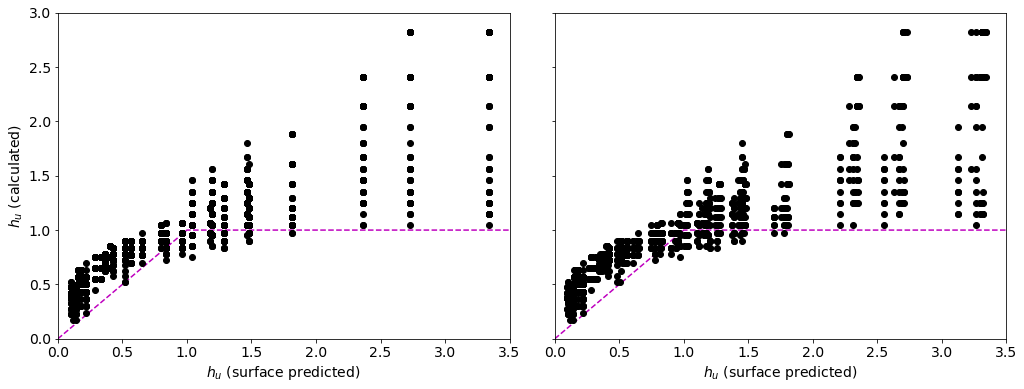

In [12]:
# Plot surface layer upwelling prediction
fig, axs = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'wspace': 0.1})

# Loop through panels and coastline angle
for ax, jtau in zip(axs, [1, runs['jtau']]):
    
    # Plot upwelling metrics
    h_u = runs['tau'] * t * jtau / (const['rho_0'] * np.sqrt(runs['g_prime'] * runs['h_s']))
    ax.plot([0, 1, 4], [0, 1, 1], 'm--')
    ax.plot(h_u / runs['h_s'], runs['h_u'] / runs['h_s'], 'ko')
    
    # Formatting
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 3])
    ax.set_xlabel('$h_u$ (surface predicted)')
    
# Final formatting
axs[0].set_ylabel('$h_u$ (calculated)')
axs[1].yaxis.set_ticklabels('')

***

### Deep layer prediction

$$h_u = \frac{H}{2\mu}\cos^{-1}\left\{1 - \frac{2S^2}{1 + S^2}\left(1 - \exp\left\{{\frac{-2\mu t}{T}}\right\}\right)\right\}, \hspace{1cm} T = \frac{\rho_0NH^2}{\tau}$$

[]

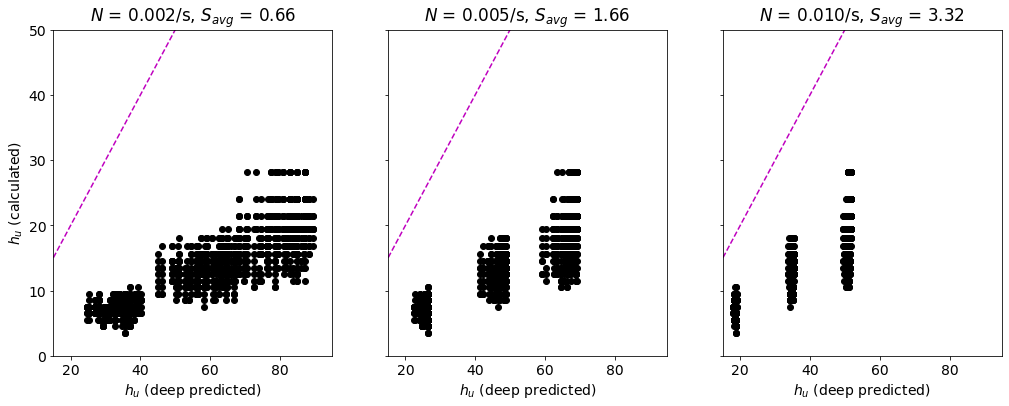

In [31]:
H = 100
fig, axs = plt.subplots(1, 3, figsize=(17, 6))

for ax, N in zip(axs, [0.002, 0.005, 0.01]):
    S = runs['slope'] * N / const['f']
    T = const['rho_0'] * N * H**2 / (runs['tau'] * runs['jtau'])
    exp = np.exp(-2 * np.arctan(S) * t / T)
    h_u = np.arccos(1 - 2 * S**2 / (1 + S**2) * (1 - exp)) * H / (2 * np.arctan(S))

    ax.plot([0, 90], [0, 90], 'm--')
    ax.plot(h_u, runs['h_u'], 'ko')
    ax.set_title(f'$N$ = {N:.3f}/s, $S_{{avg}}$ = {S.mean():.2f}')
    
    # Formatting
    ax.set_xlim([15, 95])
    ax.set_ylim([0, 50])
    ax.set_xlabel('$h_u$ (deep predicted)')
    
# Final formatting
axs[0].set_ylabel('$h_u$ (calculated)')
axs[1].yaxis.set_ticklabels('')
axs[2].yaxis.set_ticklabels('')

[]

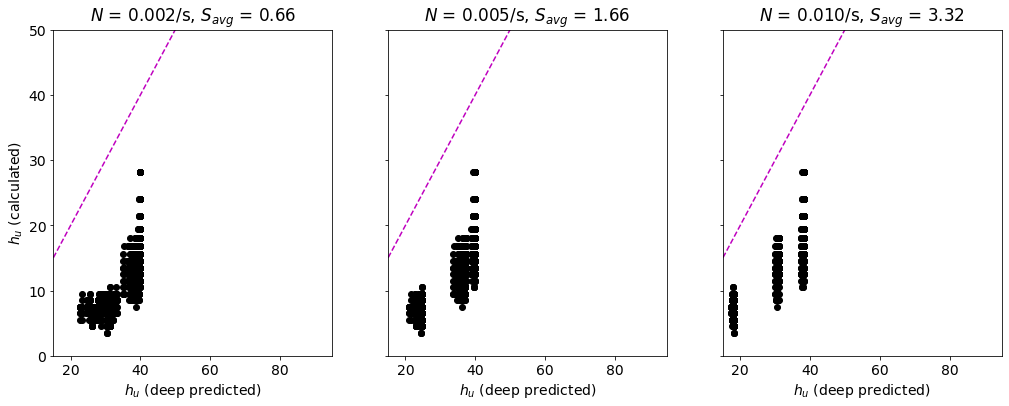

In [32]:
H = 40
fig, axs = plt.subplots(1, 3, figsize=(17, 6))

for ax, N in zip(axs, [0.002, 0.005, 0.01]):
    S = runs['slope'] * N / const['f']
    T = const['rho_0'] * N * H**2 / (runs['tau'] * runs['jtau'])
    exp = np.exp(-2 * np.arctan(S) * t / T)
    h_u = np.arccos(1 - 2 * S**2 / (1 + S**2) * (1 - exp)) * H / (2 * np.arctan(S))

    ax.plot([0, 90], [0, 90], 'm--')
    ax.plot(h_u, runs['h_u'], 'ko')
    ax.set_title(f'$N$ = {N:.3f}/s, $S_{{avg}}$ = {S.mean():.2f}')
    
    # Formatting
    ax.set_xlim([15, 95])
    ax.set_ylim([0, 50])
    ax.set_xlabel('$h_u$ (deep predicted)')
    
# Final formatting
axs[0].set_ylabel('$h_u$ (calculated)')
axs[1].yaxis.set_ticklabels('')
axs[2].yaxis.set_ticklabels('')